In [83]:
import os
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [84]:
from keras import backend

#Set seed, so that every time you run, you will get the same (reproducible) results.
SEED_VALUE = 0
os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.compat.v1.set_random_seed(SEED_VALUE)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [85]:
# Dataset is taken from https://www.kaggle.com/c/lish-moa/data
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')

test_features = pd.read_csv('../input/lish-moa/test_features.csv')
sample_submission = pd.read_csv('../input/lish-moa/sample_submission.csv')

In [86]:
train_features.drop(['sig_id'], axis='columns', inplace=True)
train_features.head(n=5)

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [87]:
train_features.loc[:, 'cp_type'] = train_features.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
train_features.loc[:, 'cp_dose'] = train_features.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})

In [88]:
test_features.loc[:, 'cp_type'] = test_features.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
test_features.loc[:, 'cp_dose'] = test_features.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})

In [89]:
train_features.head(n=5)

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,0,24,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,0,72,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,0,48,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,0,48,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,0,72,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [90]:
train_targets_scored.drop(['sig_id'], axis='columns', inplace=True)
train_targets_scored.head(n=5)

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
train_features_values = train_features.values
train_targets_values = train_targets_scored.values

In [92]:
input_dimension = train_features_values.shape[1]
output_dimension = train_targets_values.shape[1]

input_units = input_dimension
UNITS_DENSE_LAYER_1 = 128
UNITS_DENSE_LAYER_2 = 64
output_units = output_dimension

inputs = keras.Input(shape=input_units)
dense_layer1 = layers.Dense(UNITS_DENSE_LAYER_1, activation="relu", name = "dense_layer1")(inputs)
dropout_layer1 = layers.Dropout(0.5, name = "dropout_layer1")(dense_layer1)
batch_normalization_layer1 = layers.BatchNormalization(name = "batch_normalization_layer1")(dropout_layer1)

dense_layer2 = layers.Dense(UNITS_DENSE_LAYER_2, activation="relu", name = "dense_layer2")(batch_normalization_layer1)
dropout_layer2 = layers.Dropout(0.5, name = "dropout_layer2")(dense_layer2)
batch_normalization_layer2 = layers.BatchNormalization(name = "batch_normalization_layer2")(dropout_layer2)

outputs = layers.Dense(output_units, activation="sigmoid", name = "Output_Layer")(batch_normalization_layer2)

model = keras.Model(inputs=inputs, outputs=outputs, name="moa_model")

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=["accuracy"],
)

model.fit(train_features, train_targets_values, batch_size=100, epochs=75)

Epoch 1/75
239/239 [==============================] - 2s 5ms/step - loss: 0.5785 - accuracy: 0.0118
Epoch 2/75
239/239 [==============================] - 1s 5ms/step - loss: 0.0454 - accuracy: 0.0193
Epoch 3/75
239/239 [==============================] - 1s 5ms/step - loss: 0.0242 - accuracy: 0.0275
Epoch 4/75
239/239 [==============================] - 1s 5ms/step - loss: 0.0222 - accuracy: 0.0395
Epoch 5/75
239/239 [==============================] - 1s 5ms/step - loss: 0.0211 - accuracy: 0.0405
Epoch 6/75
239/239 [==============================] - 1s 5ms/step - loss: 0.0207 - accuracy: 0.0424
Epoch 7/75
239/239 [==============================] - 1s 5ms/step - loss: 0.0201 - accuracy: 0.0445
Epoch 8/75
239/239 [==============================] - 1s 6ms/step - loss: 0.0199 - accuracy: 0.0470
Epoch 9/75
239/239 [==============================] - 1s 5ms/step - loss: 0.0200 - accuracy: 0.0475
Epoch 10/75
239/239 [==============================] - 1s 5ms/step - loss: 0.0197 - accuracy: 0.0543

Model: "moa_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 875)]             0         
_________________________________________________________________
dense_layer1 (Dense)         (None, 128)               112128    
_________________________________________________________________
dropout_layer1 (Dropout)     (None, 128)               0         
_________________________________________________________________
batch_normalization_layer1 ( (None, 128)               512       
_________________________________________________________________
dense_layer2 (Dense)         (None, 64)                8256      
_________________________________________________________________
dropout_layer2 (Dropout)     (None, 64)                0         
_________________________________________________________________
batch_normalization_layer2 ( (None, 64)                25

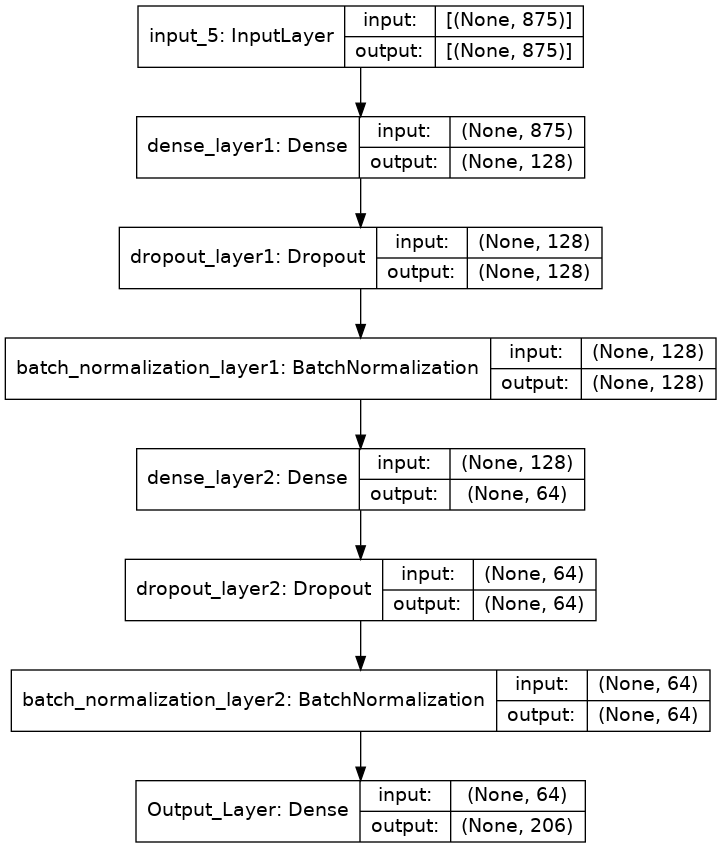

In [93]:
model.summary()
keras.utils.plot_model(model, show_shapes = True)

In [94]:
# Save the model (Serialization)
model.save('neural_network_model.h5', save_format='h5')

In [95]:
sample_submission.head(n=5)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,id_001897cda,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,id_002429b5b,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
3,id_00276f245,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
4,id_0027f1083,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [96]:
column_names=sample_submission.columns

In [97]:
test_id=x_test=test_features['sig_id'].values
x_test=test_features.drop(['sig_id'], axis='columns', inplace=False)
print(test_id)

['id_0004d9e33' 'id_001897cda' 'id_002429b5b' ... 'id_ffb710450'
 'id_ffbb869f2' 'id_ffd5800b6']


In [98]:
df = pd.DataFrame(x_test)

In [99]:
y_pred=model.predict(x_test)
print("Predictions:")
print(y_pred)
print(y_pred.shape)

Predictions:
[[1.4533699e-03 1.0771751e-03 1.3989210e-03 ... 1.8604994e-03
  1.9782782e-03 1.6273558e-03]
 [5.4150820e-04 1.3039410e-03 1.1721849e-03 ... 1.4903843e-03
  1.9849241e-03 1.2253225e-03]
 [1.0179881e-05 6.1246610e-06 2.5459380e-05 ... 4.9106588e-05
  2.0154341e-05 6.9433045e-05]
 ...
 [9.8210573e-04 5.4964423e-04 9.2557073e-04 ... 1.4021397e-03
  4.6756864e-04 1.1368096e-03]
 [1.3481379e-03 8.7854266e-04 1.2456179e-03 ... 1.6481578e-03
  7.2747469e-04 1.5016794e-03]
 [1.2073517e-03 8.2561374e-04 1.0549724e-03 ... 1.5147924e-03
  7.1817636e-04 1.2384355e-03]]
(3982, 206)


In [100]:
id_list= list(test_id)
y_pred_list= list(y_pred)

In [101]:
dictionary={}
for column in column_names:
    dictionary[column]=[]

In [102]:
print(y_pred)
print(y_pred.shape)

[[1.4533699e-03 1.0771751e-03 1.3989210e-03 ... 1.8604994e-03
  1.9782782e-03 1.6273558e-03]
 [5.4150820e-04 1.3039410e-03 1.1721849e-03 ... 1.4903843e-03
  1.9849241e-03 1.2253225e-03]
 [1.0179881e-05 6.1246610e-06 2.5459380e-05 ... 4.9106588e-05
  2.0154341e-05 6.9433045e-05]
 ...
 [9.8210573e-04 5.4964423e-04 9.2557073e-04 ... 1.4021397e-03
  4.6756864e-04 1.1368096e-03]
 [1.3481379e-03 8.7854266e-04 1.2456179e-03 ... 1.6481578e-03
  7.2747469e-04 1.5016794e-03]
 [1.2073517e-03 8.2561374e-04 1.0549724e-03 ... 1.5147924e-03
  7.1817636e-04 1.2384355e-03]]
(3982, 206)


In [103]:
column_names = list(column_names)
column_names.remove('sig_id')

In [104]:
dictionary['sig_id'] = test_id
for i in range(len(y_pred)):
    for j in range(206):
        dictionary[column_names[j]].append(y_pred[i][j])

In [105]:
df=pd.DataFrame(dictionary)

In [106]:
df.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.001453,0.001077,0.001399,0.011684,0.030283,0.005160,0.003797,0.005800,0.000360,...,0.000356,0.000900,0.002516,0.003090,0.001905,3.480017e-04,0.001064,0.001860,0.001978,0.001627
1,id_001897cda,0.000542,0.001304,0.001172,0.002844,0.005364,0.001975,0.001802,0.009208,0.000735,...,0.000384,0.001382,0.002944,0.000800,0.006968,6.058514e-04,0.008037,0.001490,0.001985,0.001225
2,id_002429b5b,0.000010,0.000006,0.000025,0.001200,0.001169,0.000087,0.000108,0.000099,0.000001,...,0.000003,0.000005,0.000087,0.000021,0.000032,9.786270e-07,0.000017,0.000049,0.000020,0.000069
3,id_00276f245,0.000368,0.000409,0.000922,0.004862,0.006693,0.001561,0.001405,0.003858,0.000103,...,0.000124,0.001373,0.001289,0.013367,0.003435,1.371205e-04,0.001933,0.000666,0.000679,0.000490
4,id_0027f1083,0.001137,0.001016,0.001430,0.015556,0.023993,0.004586,0.005076,0.002841,0.000332,...,0.000329,0.000662,0.003201,0.000983,0.000780,2.371669e-04,0.000377,0.002042,0.000583,0.001732


In [107]:
df.tail()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
3977,id_ff7004b87,0.000178,0.000288,0.000774,0.003241,0.004534,0.001066,0.001086,0.004063,0.000088,...,0.000090,0.001998,0.001041,0.020676,0.005380,0.000105,0.002848,0.000390,0.000926,0.000364
3978,id_ff925dd0d,0.001394,0.000994,0.001060,0.008086,0.026025,0.005443,0.003150,0.006657,0.000517,...,0.000218,0.000599,0.001558,0.002508,0.002236,0.000216,0.002506,0.001366,0.000857,0.001330
3979,id_ffb710450,0.000982,0.000550,0.000926,0.010591,0.025179,0.004488,0.003314,0.004099,0.000223,...,0.000181,0.000419,0.001451,0.000917,0.000959,0.000117,0.000937,0.001402,0.000468,0.001137
3980,id_ffbb869f2,0.001348,0.000879,0.001246,0.010998,0.026804,0.005281,0.003695,0.004458,0.000329,...,0.000242,0.000611,0.001882,0.001797,0.001503,0.000185,0.001152,0.001648,0.000727,0.001502
3981,id_ffd5800b6,0.001207,0.000826,0.001055,0.009906,0.025959,0.004811,0.003326,0.004997,0.000296,...,0.000227,0.000587,0.001721,0.001460,0.001333,0.000196,0.001130,0.001515,0.000718,0.001238


In [108]:
df.to_csv('./submission.csv',index=False)